## Imports etc.

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pyemma as pe
import pyemma
import torch  # pytorch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import mdtraj

In [2]:
sys.path.insert(0,'../')
from torchmdnet2.dataset import ChignolinDataset, DataModule
from torchmdnet2.nn import CGnet
from torchmdnet2.models import LNNP, SchNet, MLPModel
from torchmdnet2.utils import LoadFromFile, save_argparse
from torchmdnet2.simulation import Simulation

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

from pytorch_lightning.plugins import DDPPlugin

from torch_geometric.data import DataLoader

from torch.nn import Embedding, Sequential, Linear, ModuleList

In [3]:
device = torch.device('cuda')

## Utils

In [4]:
def plot_tica(baseline_model, dataset, lag=10, tica=None):
    # compute distances all of the beads
    baseline_model.cpu()  # moves the tensors onto the cpu
    if isinstance(dataset, np.ndarray):  # check if the dataset is an numpy array
        n_traj, n_samp, n_beads, _ = traj.shape
        features = []
        for i_traj in range(n_traj):
            _ = baseline_model.geom_feature(torch.from_numpy(traj[i_traj]))
            feat = baseline_model.geom_feature.distances
            features.append(feat)
    else:
        _ = baseline_model.geom_feature(dataset.data.pos.reshape((-1, baseline_model.n_beads, 3)))
        feat = baseline_model.geom_feature.distances

        if 'traj_idx' in dataset.data:
            traj_ids = dataset.data.traj_idx
            n_traj = np.unique(traj_ids).shape[0]
            traj_strides = np.cumsum([0]+(np.bincount(traj_ids)).tolist(), dtype=int)

            features = []
            for i_traj in range(n_traj):
                st, nd = traj_strides[i_traj], traj_strides[i_traj+1]
                features.append(feat[st:nd].numpy())
        else:
            features = feat.numpy()
            
    if tica is None:
        tica = pe.coordinates.tica(features, lag=lag, dim=2)
        tica_concatenated = np.concatenate(tica.get_output())
    else:
        Xproj = tica.transform(features)
        tica_concatenated = np.concatenate(Xproj)

    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    pyemma.plots.plot_feature_histograms(
        tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
    pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
    pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
    for ax in axes.flat[1:]:
        ax.set_xlabel('IC 1')
        ax.set_ylabel('IC 2')
    fig.tight_layout()
    return fig, axes, tica

In [5]:
from torch_geometric.data.data import size_repr

from argparse import Namespace
class Args(Namespace):
    def __init__(self,**kwargs):
        for key, item in kwargs.items():
            self[key] = item
            
    def __getitem__(self, key):
        r"""Gets the data of the attribute :obj:`key`."""
        return getattr(self, key, None)

    def __setitem__(self, key, value):
        """Sets the attribute :obj:`key` to :obj:`value`."""
        setattr(self, key, value)

    @property
    def keys(self):
        r"""Returns all names of graph attributes."""
        keys = [key for key in self.__dict__.keys() if self[key] is not None]
        keys = [key for key in keys if key[:2] != '__' and key[-2:] != '__']
        return keys

    def __len__(self):
        r"""Returns the number of all present attributes."""
        return len(self.keys)

    def __contains__(self, key):
        r"""Returns :obj:`True`, if the attribute :obj:`key` is present in the
        data."""
        return key in self.keys

    def __iter__(self):
        r"""Iterates over all present attributes in the data, yielding their
        attribute names and content."""
        for key in sorted(self.keys):
            yield key, self[key]

    def __call__(self, *keys):
        r"""Iterates over all attributes :obj:`*keys` in the data, yielding
        their attribute names and content.
        If :obj:`*keys` is not given this method will iterative over all
        present attributes."""
        for key in sorted(self.keys) if not keys else keys:
            if key in self:
                yield key, self[key]
                
    def __repr__(self):
        cls = str(self.__class__.__name__)
        has_dict = any([isinstance(item, dict) for _, item in self])

        if not has_dict:
            info = [size_repr(key, item) for key, item in self]
            return '{}({})'.format(cls, ', '.join(info))
        else:
            info = [size_repr(key, item, indent=2) for key, item in self]
            return '{}(\n{}\n)'.format(cls, ',\n'.join(info))

## Reference TICA

In [6]:
chignolin_dataset = ChignolinDataset('/local_scratch/hoffmae99/bachelor/datasets/chignolin/')
baseline_model = chignolin_dataset.get_baseline_model(n_beads=10)  # doesn't work without specifying n_beads

In [13]:
chignolin_dataset[0].n_atoms

tensor([10])

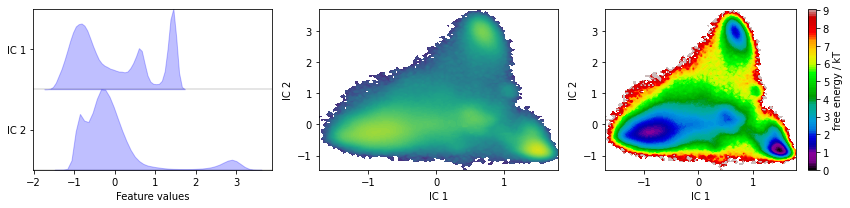

In [7]:
_,_, tica = plot_tica(baseline_model, chignolin_dataset, lag=10)

## CGSchNet TICA

### preparation

In [8]:
# model = torch.load("/local_scratch/hoffmae99/bachelor/chign/test_0/last_model.pt")
model = torch.load("/local_scratch/hoffmae99/bachelor/chign/test_0/epoch=99-val_loss=0.0000-test_loss=0.0000.ckpt")
# model = SchNet.load_from_checkpoint("/local_scratch/hoffmae99/bachelor/chign/test_0/last_model.pt")

# gives an error if last_model.pt is used

In [9]:
n_sims = 1000
n_timesteps = 10000
save_interval = 10

In [10]:
ids = np.arange(0, len(chignolin_dataset),len(chignolin_dataset)//n_sims).tolist()
init = chignolin_dataset[ids]
initial_coords = torch.cat([init[i].pos.reshape((1,-1,3)) for i in range(len(init))], dim=0).to(device=device)
initial_coords.requires_grad_()

sim_embeddings = torch.cat([init[i].z.reshape((1,-1)) for i in range(len(init))], dim=0).to(device=device)

chignolin_net = CGnet(model, baseline_model).eval()
chignolin_net.to(device=device)

CGnet(
  (baseline): BaselineModel(
    (geom_feature): GeometryFeature()
    (priors): Sequential(
      (0): HarmonicLayer()
      (1): HarmonicLayer()
      (2): RepulsionLayer()
    )
  )
)

In [11]:
sim = Simulation(chignolin_net, initial_coords, sim_embeddings, length=n_timesteps,
                 save_interval=save_interval, beta=baseline_model.beta,
                 save_potential=True, device=device,
                 log_interval=100, log_type='print')

traj = sim.simulate()

Generating 1001 simulations of length 10000 saved at 10-step intervals (Mon Aug 16 16:39:30 2021)


TypeError: 'dict' object is not callable

### plot

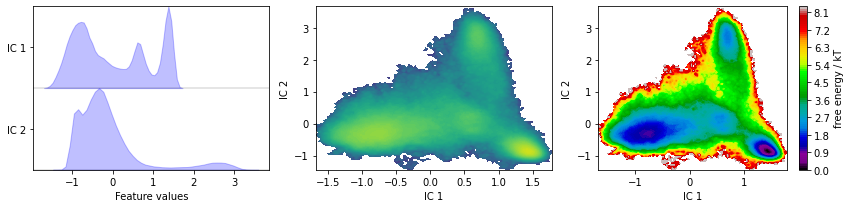

In [ ]:
_,_,_ = plot_tica(baseline_model, traj, tica=tica)

## MLP Version 1

In [ ]:
model1 = MLPModel.load_from_checkpoint("/local_scratch/hoffmae99/bachelor/chign/test_1/epoch=5-validation_loss=27.2908-test_loss=0.0000.ckpt")

In [ ]:
n_sims = 1000
n_timesteps = 10000
save_interval = 10

In [ ]:
# initializing the simulation states
ids = np.arange(0, len(chignolin_dataset),len(chignolin_dataset)//n_sims).tolist()
init = chignolin_dataset[ids]
initial_coords = torch.cat([init[i].pos.reshape((1,-1,3)) for i in range(len(init))], dim=0).to(device=device)
initial_coords.requires_grad_()

sim_embeddings = torch.cat([init[i].z.reshape((1,-1)) for i in range(len(init))], dim=0).to(device=device)

# initializing the Net with the learned weights and biases and preparing it for evaluation
chignolin_net1 = CGnet(model1, baseline_model).eval()
chignolin_net1.to(device=device)

CGnet(
  (model): MLPModel(
    (calculator): PowerSpectrum(
      (se): SphericalExpansion(
        (cutoff): ShiftedCosineCutoff()
        (Rln): NaturalCubicSpline()
        (Ylm): SphericalHarmonics()
      )
    )
    (mlp): MLP(
      (layers): Sequential(
        (0): Linear(in_features=13120, out_features=500, bias=True)
        (1): Tanh()
        (2): Linear(in_features=500, out_features=500, bias=True)
        (3): Tanh()
        (4): Linear(in_features=500, out_features=350, bias=True)
        (5): Tanh()
        (6): Linear(in_features=350, out_features=200, bias=True)
        (7): Tanh()
        (8): Linear(in_features=200, out_features=100, bias=True)
        (9): Tanh()
        (10): Linear(in_features=100, out_features=1, bias=False)
      )
    )
  )
  (baseline): BaselineModel(
    (geom_feature): GeometryFeature()
    (priors): Sequential(
      (0): HarmonicLayer()
      (1): HarmonicLayer()
      (2): RepulsionLayer()
    )
  )
)

In [ ]:
# simulating
sim1 = Simulation(chignolin_net1, initial_coords, sim_embeddings, length=n_timesteps,
                 save_interval=save_interval, beta=baseline_model.beta,
                 save_potential=True, device=device,
                 log_interval=100, log_type='print')

traj1 = sim1.simulate()

Generating 1001 simulations of length 10000 saved at 10-step intervals (Mon Aug 16 16:36:47 2021)


TypeError: forward() takes 2 positional arguments but 4 were given